This notebook details the process of generating the topics from the articles using CovidBERT embeddings

In [1]:
%config Completer.use_jedi=False
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import os
import json
import re
import requests
from collections import Counter
import joblib

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation 
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from tsnecuda import TSNE
tqdm_notebook().pandas()

In [3]:
export_path = "../data/exports_v3/"

load previously saved metadata

In [4]:
metadata = pd.read_csv(os.path.join(export_path, 'metadata.csv'))

load saved excerpts embeddings

In [5]:
embeddings = np.load(os.path.join(export_path,'embeddings_excerpts.npy'))

Reduced embedding to 250 PCA components and retain 0.95 of the explained variance

In [6]:
pca = PCA(n_components=250)
embeddings_reduced_pca = pca.fit_transform(embeddings)
print(f'cumulated variance : {pca.explained_variance_ratio_.sum()}')

cumulated variance : 0.9519860744476318


Reduce PCA components to tSNE components. Use a cuda implementation of tsne: tsnecuda

In [7]:
tsne = TSNE(perplexity=150, n_iter=1000)
embeddings_reduced_tsne = tsne.fit_transform(embeddings_reduced_pca)

Save tSNE coordinates

In [8]:
df_tsne_coordiantes = pd.DataFrame(embeddings_reduced_tsne, columns=['x1', 'x2'])
df_tsne_coordiantes.to_csv(os.path.join(export_path, 'tsne_coordinates.csv'), index=False)

Apply a clustering on the PCA components

In [9]:
n_clusters = 8
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=1000)
predicted_labels = kmeans.fit_predict(embeddings_reduced_pca)

Compute the silhouette scores

In [10]:
silhouette = silhouette_score(embeddings_reduced_pca, predicted_labels, n_jobs=10)
sample_silhouette_values = silhouette_samples(embeddings_reduced_pca, predicted_labels, n_jobs=10)

Plot the silouhette scores per clusters and the tSNE visualization of the clusters

Text(0.5, 1.0, 'tSNE representation of the data')

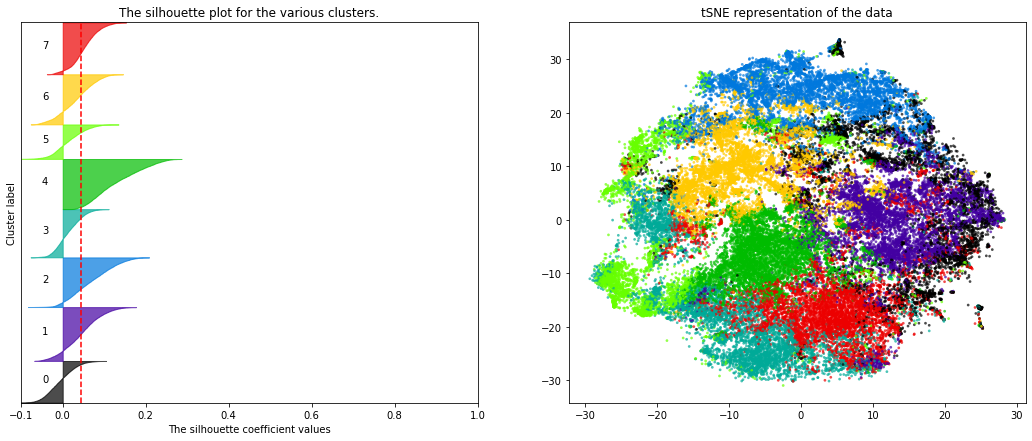

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(embeddings) + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[predicted_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

colors = cm.nipy_spectral(predicted_labels.astype(float) / n_clusters)
ax2.scatter(embeddings_reduced_tsne[:, 0], embeddings_reduced_tsne[:, 1], 
            marker='.', 
            s=30, 
            lw=0, 
            alpha=0.7,
            c=colors, 
            edgecolor='k')

ax2.set_title("tSNE representation of the data")

### Interpreting clusters

Define a Lamma-Tokenizer

In [12]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc.split()]
lemma_tokenizer = LemmaTokenizer()    

Define a list of stopword

In [13]:
response = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt")
STOPWORDS = response.text.split('\n')

response_fr = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt")
STOPWORDS_FR = response_fr.text.split('\n')
STOPWORDS += STOPWORDS_FR

STOPWORDS += ["et", "al", "fig", "figure", "can", "may", "also", "doi", "biorxiv", "preprint",
              "copyright", "peer-reviewed", "authorfunder", "table", "license", "à", "chapter",
             "abstract", "issue", "acute", "study", "approach", "inde", "index", "author", "unknown"]

STOPWORDS += ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 'mustn', 
              'myse', 'needn', 'oughtn', 'peer', 'reviewed', 'shan']

STOPWORDS += ["'d", "'m", "'re", "'s", "'t", '.', 'affect', 'change', 'doe', 'greeting', 'ha', 
              'i.e', 'key', 'le', "n't", 'regard', 'result', 'sha', 'ti', 'wa', 'wo', 'word', 
              '”', 'avon', 'diver', 'fuss', 'gen', 'quantum', 'serum', 'somme', 'sou']

STOPWORDS += ['respiratory', 'virus', 'infectious', 'disease', 'influenza', 'syndrome', 'infection', 
              'coronavirus', 'covid', 'mers', 'sars', 'cov', 'viral']

STOPWORDS += ['µ', 'µg', 'µl', 'µm', '¼', 'å', 'þ', 'β', 'β actin', 'β β', 'δ', 'ε', 'η', 'θ', 
              'κ', 'κb', 'λ', 'μ', 'μg', 'μl', 'μm', 'π', 'ρ', 'σ', 'φ', 'ω', 'α', 'γ', 'medrxiv']

In [14]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http?://\S+", "", text)
    text = re.sub(r"\s\d+\s", " ", text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

Clean the excerpt

In [15]:
texts = metadata[['excerpt', 'body_text']].copy()
texts['cluster'] = predicted_labels
texts['excerpt'] = texts.excerpt.progress_map(preprocess)

In [16]:
def get_keywords(model, feature_names, n_top_words):
    keywords = []
    for topic_idx, topic in enumerate(model.components_):
        keywords += [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    
    keywords = list(set(keywords))
    return keywords

fit a tf-idf vectorizer on all data

In [ ]:
full_vectorizer = TfidfVectorizer(max_df=0.9, 
                                 min_df=0.01,
                                 stop_words=STOPWORDS, 
                                 ngram_range=(1, 2), 
                                 tokenizer=lemma_tokenizer)
full_vectorizer.fit(tqdm_notebook(texts['excerpt'].tolist(), leave=False))
feature_names = full_vectorizer.get_feature_names()

Interpret the keywords of each cluster using LDA

In [19]:
cluster_info = {}


for k in tqdm_notebook(range(n_clusters)):

    topn = 20
    cluster_info[k] = {}
    
    train = texts[texts['cluster'] != k]['excerpt'].tolist()
    docs = texts[texts['cluster'] == k]['excerpt'].tolist()
    
    # generate tfidf vectors per clusters
    
    docs_vectors = full_vectorizer.transform(tqdm_notebook(docs, leave=False))
    
    # fit an lda on these vectors
    N_topics = 2
    
    lda = LatentDirichletAllocation(n_components=N_topics, 
                                    max_iter=20,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(docs_vectors)
    
    # extract the top keywords of each topic
    
    keywords = get_keywords(lda, feature_names, int(20 / N_topics))
    
    
    cluster_info[k]['keywords'] = keywords

    print(f'cluster : {k}')    
    print(f'keywords : {keywords}')
    print("----\n")

cluster : 0
keywords : ['severe', 'drug', 'animal', 'anti', 'therapy', 'clinical', 'activity', 'lung', 'cell', 'acid', 'compound', 'blood', 'pulmonary', 'care', 'human', 'method', 'treatment', 'patient', 'risk']
----



cluster : 1
keywords : ['severe', 'tract', 'pneumonia', 'method', 'hospital', 'illness', 'pulmonary', 'patient', 'care', 'lung', 'outcome', 'clinical', 'hospitalized', 'risk', 'child', 'background', 'mortality', 'treatment']
----



cluster : 2
keywords : ['innate', 'protein', 'host', 'gene', 'cellular', 'induced', 'receptor', 'mouse', 'interferon', 'cell', 'membrane', 'response', 'immune', 'replication', 'human', 'role', 'rna', 'immune response', 'expression']
----



cluster : 3
keywords : ['global', 'public health', 'animal', 'health', 'public', 'emerging', 'social', 'development', 'pathogen', 'review', 'country', 'epidemic', 'data', 'human', 'international', 'outbreak', 'pandemic', 'population', 'model', 'science']
----



cluster : 4
keywords : ['severe', 'wuhan', 'confirmed', 'east', 'health', 'middle east', 'spread', 'caused', 'clinical', 'china', 'country', 'middle', 'human', 'december', 'treatment', 'outbreak', 'march', 'patient', 'pandemic']
----



cluster : 5
keywords : ['application', 'protein', 'paper', 'drug', 'sequence', 'structure', 'development', 'network', 'epidemic', 'data', 'time', 'method', 'biological', 'technology', 'based', 'dynamic', 'learning', 'model', 'detection']
----



cluster : 6
keywords : ['severe', 'family', 'specie', 'host', 'animal', 'east', 'sequence', 'cell', 'pathogen', 'diarrhea', 'vaccine', 'sample', 'human', 'pedv', 'porcine', 'pig', 'strain', 'assay', 'detection', 'coronaviruses']
----



cluster : 7
keywords : ['health care', 'health', 'medical', 'public', 'review', 'hospital', 'vaccine', 'patient', 'clinical', 'care', 'management', 'pandemic', 'healthcare', 'risk', 'cancer', 'emergency', 'mortality', 'treatment']
----




In [ ]:
clusters_definitions = {}
for i in range(n_clusters):
    clusters_definitions[f'cluster_{i}'] = ''

attribute a title to the clusters

In [ ]:
clusters_definitions  =  {'0': 'Drug testing',
                          '1': 'Covid outbreak',
                          '2': 'Detection',
                          '3': 'Treatments',
                          '4': 'Genetic studies',
                          '5': 'Transmission',
                          '6': 'Crisis management',
                          '7': 'Immunity studies'
                         }

for k in cluster_info:
    cluster_info[k]['topic'] = clusters_definitions[str(k)]

save kmeans model

In [ ]:
joblib.dump(kmeans, os.path.join(export_path, 'kmeans.joblib'))

### Extract keywords for each article

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http?://\S+", "", text)
    text = re.sub(r"\s\d+\s", " ", text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

In [ ]:
response = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt")
STOPWORDS = response.text.split('\n')

response_fr = requests.get("https://raw.githubusercontent.com/stopwords-iso/stopwords-fr/master/stopwords-fr.txt")
STOPWORDS_FR = response_fr.text.split('\n')
STOPWORDS += STOPWORDS_FR

STOPWORDS += ["et", "al", "fig", "figure", "can", "may", "also", "doi", "biorxiv", "preprint",
              "copyright", "peer-reviewed", "authorfunder", "table", "license", "à", "chapter",
             "abstract", "issue", "acute", "study", "approach", "inde", "index", "author", "unknown"]

STOPWORDS += ['ain', 'daren', 'hadn', 'herse', 'himse', 'itse', 'mayn', 'mightn', 'mon', 
              'mustn', 'myse', 'needn', 'oughtn', 'peer', 'reviewed', 'shan']

STOPWORDS += ["'d", "'m", "'re", "'s", "'t", '.', 'affect', 'change', 'doe', 'greeting', 'ha', 'i.e', 'key', 
               'le', "n't", 'regard', 'result', 'sha', 'ti', 'wa', 'wo', 'word', '”',
              'avon', 'diver', 'fuss', 'gen', 'quantum', 'serum', 'somme', 'sou']

STOPWORDS += ['respiratory', 'virus', 'infectious', 'disease', 'influenza', 'syndrome', 'infection', 
              'coronavirus', 'covid', 'mers', 'sars', 'cov', 'viral'] + ['µ', 'µg', 'µl', 'µm', 
            '¼', 'å', 'þ', 'β', 'β actin', 'β β', 'δ', 'ε', 'η', 'θ', 'κ', 'κb', 'λ', 'μ', 'μg', 
            'μl', 'μm', 'π', 'ρ', 'σ', 'φ', 'ω', 'α', 'γ', 'medrxiv']


In [ ]:
texts['preproc_body_text'] = texts.body_text.progress_map(preprocess)

In [ ]:
full_text_vectorizer = TfidfVectorizer(max_features=10000,
                                       max_df=0.8, 
                                       min_df=0.05,
                                       stop_words=STOPWORDS, 
                                       ngram_range=(1, 2), 
                                       tokenizer=lemma_tokenizer)

vectors = full_text_vectorizer.fit_transform(tqdm_notebook(
    texts['preproc_body_text'].map(lambda t: t[:40000]).tolist(), leave=False))

In [ ]:
feature_name_all = full_text_vectorizer.get_feature_names()
feature_name_all = np.array(feature_name_all)

In [ ]:
keywords_list = []

for i in tqdm_notebook(range(vectors.shape[0])):
    row = vectors[i]
    row = row.tocoo()

    tuples = zip(row.col, row.data)
    tuples = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
    
    indices = [c[0] for c in tuples[:10]]
    keywords = feature_name_all[indices].tolist()
    
    keywords_list.append(keywords)

In [ ]:
df_keywords = pd.DataFrame(keywords_list)

In [ ]:
df_keywords['paper_id'] = metadata.paper_id

In [ ]:
df_keywords = df_keywords[['paper_id'] + list(range(10))]

In [ ]:
df_keywords.to_csv(os.path.join(export_path, 'keywords_per_doc.csv'), index=False)

### Consolidate outputs:

In [ ]:
cluster_data_front = pd.DataFrame()
cluster_data_front['key'] = range(n_clusters)
cluster_data_front['label'] = cluster_data_front['key'].map(str)
cluster_data_front['topic'] = cluster_data_front.label.map(clusters_definitions)

In [ ]:
cluster_data_front.to_json(orient='records')

In [ ]:
df_output = pd.DataFrame(embeddings_reduced_tsne, columns=['x1', 'x2'])
df_output['cluster'] = predicted_labels
df_output['paper_id'] = metadata.paper_id

df_output = df_output[['paper_id', 'x1', 'x2', 'cluster']]

In [ ]:
df_output.to_csv(os.path.join(export_path, 'clusters.csv'), index=False)

In [ ]:
with open(os.path.join(export_path, 'clusters_info.json'), 'w') as f:
    json.dump(cluster_info, f)

In [ ]:
metadata.drop(['preproc_body_text', 'preprint', 'language', 'subjects'], inplace=True, axis=1)

In [ ]:
metadata.to_csv(os.path.join(export_path, 'metadata.csv'))

In [ ]:
metadata.source_x.value_counts()